# Plot Rapid Intensification Metrics
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria
##### version: v0.2.0

In [48]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from build_data import build_hurricane_data
import model_diagnostics
import prediction
import pandas as pd
import scipy.stats
import sklearn.metrics

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

dpiFig = 400

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [49]:
__author__ = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "03 June 2022"

EXP_NAME_LIST = (
                 "intensity201_AL24",
                 "intensity202_AL48",    
                 "intensity203_AL72",
                 "intensity204_AL96",    
                 "intensity205_AL120",    
    
                 "intensity301_EPCP24",
                 "intensity302_EPCP48",    
                 "intensity303_EPCP72",
                 "intensity304_EPCP96",    
                 "intensity305_EPCP120",        
                 )

APPEND_NAME = ''#'_paper'

DATA_PATH = "data/"
MODEL_PATH = "saved_models/"
METRIC_PATH = "saved_metrics/"
FIGURE_PATH = "figures/paper_figures/"
PREDICTION_PATH = "saved_predictions/"

## Plotting functions

In [50]:
FS = 16

### for white background...
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

## Plot RI metrics

To access the correct data, make sure you have recently run the following on all SHASH predictions of interest.
* ```_plot_metrics.ipynb```
* ```_compute_shashPrediction.ipynb```

In [51]:
RI_THRESH_DICT = {24: 30,
                  48: 55,
                  72: 65,
                  96: None,
                  120: None,
                 }

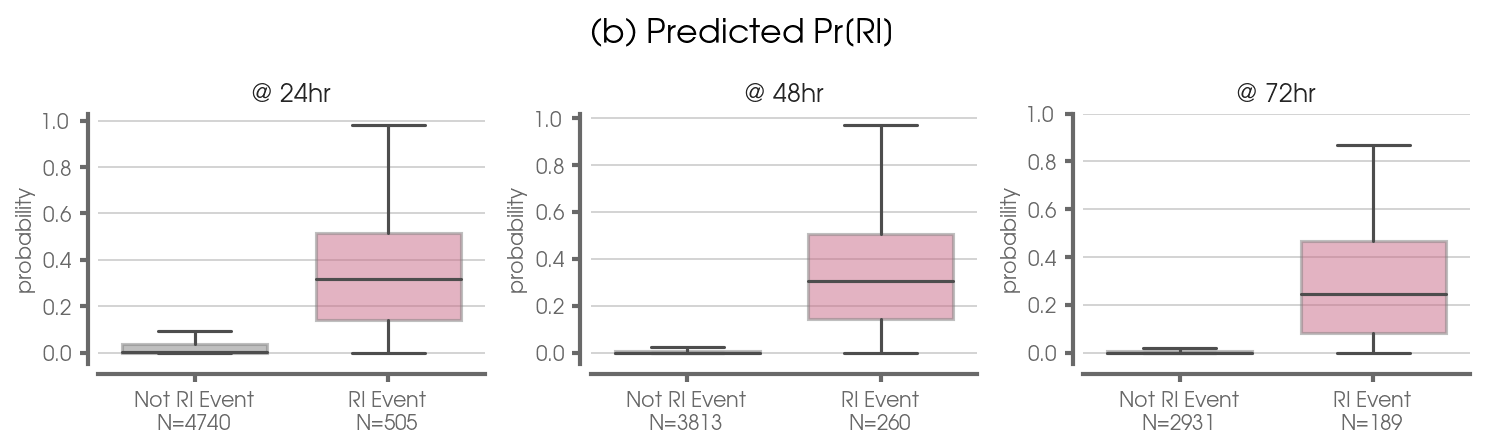

In [52]:
df_bestpred = pd.read_csv(PREDICTION_PATH + "shash3_bestValTestingPredictions.csv")
df_all_ri = pd.DataFrame()

colors = ('gray','#D95980','#E1A730','#C3B1E1','#351F27','#A9C961')
#------------------------------------------------------------
fig, axs = plt.subplots(1,3,figsize=(10,3))
for iloop, PLOT_LEAD in enumerate((24, 48, 72)):

    df_bestpred_ri = df_bestpred[df_bestpred["ftime(hr)"]==PLOT_LEAD]
    true_vmx = df_bestpred_ri["OBDV"]+df_bestpred_ri["VMXC"]

    # true RI events
    i = np.where(true_vmx >= df_bestpred_ri["VMAX0"]+RI_THRESH_DICT[PLOT_LEAD])
    ri_pred = df_bestpred_ri.iloc[i]
    ri_pred_plot = ri_pred[["shash_pr_ri"]].melt(var_name='prob_type', value_name='probability')

    # not RI events
    i = np.where(true_vmx < df_bestpred_ri["VMAX0"]+RI_THRESH_DICT[PLOT_LEAD])
    nori_pred = df_bestpred_ri.iloc[i]
    nori_pred_plot = nori_pred[["shash_pr_ri"]].melt(var_name='prob_type', value_name='probability')
    nori_pred_plot["prob_type"] = 'shash_pr_nori'

    # concatenate
    ri_plot_df = pd.concat([nori_pred_plot,ri_pred_plot])

    ax = axs[iloop]
    sns.boxplot(x = "prob_type",
                y = "probability",
                data=ri_plot_df,
                palette=colors,
                width=.75,
                dodge=False,
                boxprops={'alpha':.5,
                          'edgecolor': 'gray',
                          },
                fliersize=0,
                ax=ax,
                )
    # sns.swarmplot(x = "prob_type",
    #             y = "probability",
    #             data=ri_plot_df,
    #             palette=colors,
    #             dodge=False,
    #             size=3,
    #             alpha=.3,
    #             ax=ax,
    #            )
    yticks = np.around(np.arange(0,1.2,.2),2)
    ax.set_yticks(yticks,yticks)
    ax.set_xlabel(None)
    ax.set_title('@ ' + str(PLOT_LEAD) + 'hr')
    format_spines(ax)
    ax.set_xticks((0,1),('Not RI Event\nN=' + str(len(nori_pred_plot)),'RI Event\nN='+ str(len(ri_pred_plot))))

plt.suptitle('(b) Predicted Pr[RI]', fontsize=FS, color='k')

plt.tight_layout()
plt.savefig(FIGURE_PATH + 'ri_probabilities_allTesting_ALEPCP' + '.png', dpi=dpiFig)
plt.show()

## Significance and Precision-Recall Curves for RI
These were requested by the reviewers.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
https://medium.com/@douglaspsteen/precision-recall-curves-d32e5b290248
https://www.statology.org/precision-recall-curve-python/

PLOT_LEAD = 24
MannwhitneyuResult(statistic=2158187.0, pvalue=4.515821196900756e-194)
PLOT_LEAD = 48
MannwhitneyuResult(statistic=917118.0, pvalue=8.90422191398748e-117)
PLOT_LEAD = 72
MannwhitneyuResult(statistic=504321.0, pvalue=5.095303698195525e-80)


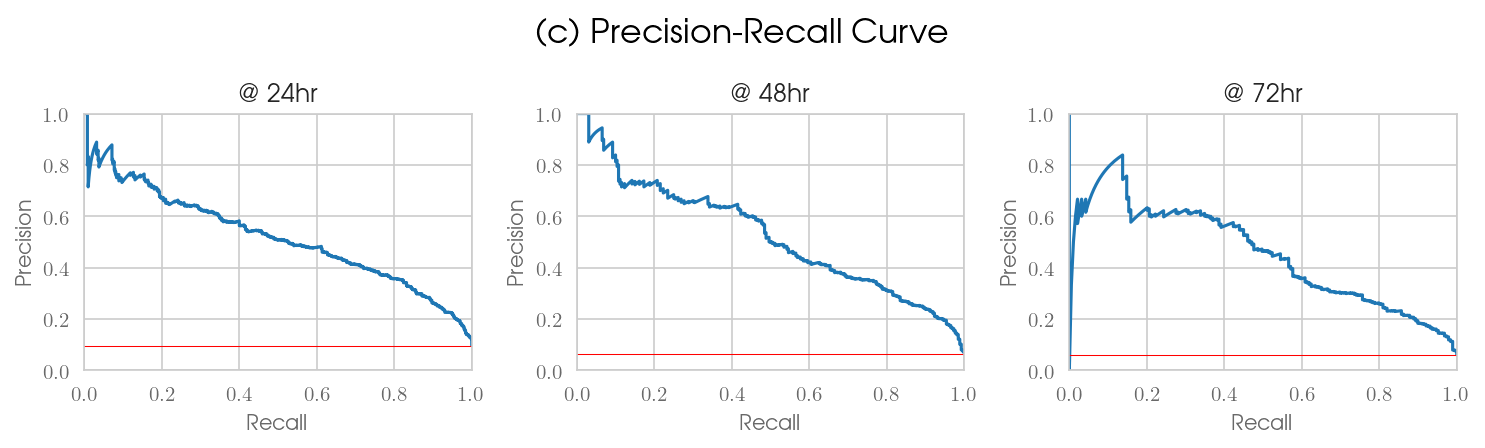

In [63]:
df_bestpred = pd.read_csv(PREDICTION_PATH + "shash3_bestValTestingPredictions.csv")

colors = ('gray','#D95980','#E1A730','#C3B1E1','#351F27','#A9C961')
#------------------------------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(10,3))
for iloop, PLOT_LEAD in enumerate((24, 48, 72)):

    df_bestpred_ri = df_bestpred[df_bestpred["ftime(hr)"]==PLOT_LEAD]
    true_vmx = df_bestpred_ri["OBDV"]+df_bestpred_ri["VMXC"]

    # true RI events
    i = np.where(true_vmx >= df_bestpred_ri["VMAX0"]+RI_THRESH_DICT[PLOT_LEAD])
    ri_pred = df_bestpred_ri.iloc[i]
    ri_pred_plot = ri_pred[["shash_pr_ri"]].melt(var_name='prob_type', value_name='probability')

    # not RI events
    i = np.where(true_vmx < df_bestpred_ri["VMAX0"]+RI_THRESH_DICT[PLOT_LEAD])
    nori_pred = df_bestpred_ri.iloc[i]
    nori_pred_plot = nori_pred[["shash_pr_ri"]].melt(var_name='prob_type', value_name='probability')
    nori_pred_plot["prob_type"] = 'shash_pr_nori'

    # concatenate
    ri_plot_df = pd.concat([nori_pred_plot,ri_pred_plot])

    # Apply a Mann Whitney U test of significanse for the probabilities.
    res = scipy.stats.mannwhitneyu(
        x=ri_pred_plot["probability"],
        y=nori_pred_plot["probability"],
        alternative='two-sided'
    )
    print(f"{PLOT_LEAD = }")
    print(f"{res}")

    # Calculate precision and recall at a host of thresholds.
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(
        ri_plot_df["prob_type"],
        ri_plot_df["probability"],
        pos_label='shash_pr_ri'
    )
    baseline = len(ri_plot_df[ri_plot_df["prob_type"]=="shash_pr_ri"])/len(ri_plot_df)
    ax = axs[iloop]
    ax.plot(recall, precision)
    ax.axhline(baseline, color='r', linewidth=0.5)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title('@ ' + str(PLOT_LEAD) + 'hr')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

plt.suptitle('(c) Precision-Recall Curve', fontsize=FS, color='k')
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'ri_precision_recal_allTesting_ALEPCP' + '.png', dpi=dpiFig)
plt.show()


# Comparing to consensus Pr(RI)

In [54]:
error('here')

NameError: name 'error' is not defined

In [ ]:
df_bestpred = pd.read_csv(PREDICTION_PATH + "shash3_bestValTestingPredictions.csv")

colors = ('#E1A730','#284E60','#E1A730','#C3B1E1','#351F27','#A9C961')
#------------------------------------------------------------
fig, axs = plt.subplots(1,3,figsize=(10,3))
for iloop, PLOT_LEAD in enumerate((24, 48, 72)):
    
    df_bestpred_ri = df_bestpred[df_bestpred["ftime(hr)"]==PLOT_LEAD]

    true_vmx = df_bestpred_ri["OBDV"]+df_bestpred_ri["VMXC"]
    i = np.where(true_vmx >= df_bestpred_ri["VMAX0"]+RI_THRESH_DICT[PLOT_LEAD])
    ri_pred = df_bestpred_ri.iloc[i]
    # display(ri_pred[["Name","year","time","ftime(hr)","VMAX0","VMXC","shash_pr_ri","clim_pr_ri"]])

    ri_pred_plot = ri_pred[["clim_pr_ri","shash_pr_ri"]].melt(var_name='prob_type', value_name='probability')


    ax = axs[iloop]
    sns.boxplot(x = "prob_type",
                y = "probability",
                data=ri_pred_plot,
                palette=colors,
                width=.75,
                dodge=False,
                boxprops={'alpha':1.,
                       'edgecolor': 'gray',
                      },
                fliersize=0,
                ax=ax,
               )
    # sns.swarmplot(x = "prob_type",
    #             y = "probability",
    #             data=ri_pred_plot,
    #             palette=colors,
    #             dodge=False,
    #             size=3,
    #             ax=ax,
    #            )
    yticks = np.around(np.arange(0,1.2,.2),2)
    ax.set_yticks(yticks,yticks)
    ax.set_xlabel(None)
    ax.set_title('@ ' + str(PLOT_LEAD) + 'hr')
    format_spines(ax)
    
plt.suptitle('Predicted Pr[RI] for True RI Events (AL \& EP/CP)', fontsize=FS, color='k')    

plt.tight_layout()
plt.savefig(FIGURE_PATH + 'ri_probabilities_allTesting_ALEPCP' + '.png', dpi=dpiFig)     
plt.show()
# plt.show()


In [ ]:
df_bestpred = pd.read_csv(PREDICTION_PATH + "shash3_bestValTestingPredictions.csv")

colors = ('#E1A730','#284E60','#E1A730','#C3B1E1','#351F27','#A9C961')
#------------------------------------------------------------
fig, axs = plt.subplots(1,3,figsize=(10,3))
for iloop, PLOT_LEAD in enumerate((24, 48, 72)):
    
    df_bestpred_ri = df_bestpred[df_bestpred["ftime(hr)"]==PLOT_LEAD]

    true_vmx = df_bestpred_ri["OBDV"]+df_bestpred_ri["VMXC"]
    i = np.where(true_vmx < df_bestpred_ri["VMAX0"]+RI_THRESH_DICT[PLOT_LEAD])
    ri_pred = df_bestpred_ri.iloc[i]
    # display(ri_pred[["Name","year","time","ftime(hr)","VMAX0","VMXC","shash_pr_ri","clim_pr_ri"]])

    ri_pred_plot = ri_pred[["clim_pr_ri","shash_pr_ri"]].melt(var_name='prob_type', value_name='probability')

    ax = axs[iloop]
    sns.boxplot(x = "prob_type",
                y = "probability",
                data=ri_pred_plot,
                palette=colors,
                width=.75,
                dodge=False,
                boxprops={'alpha':.5,
                       'edgecolor': 'gray',
                      },
                fliersize=0,
                ax=ax,
               )
    # sns.swarmplot(x = "prob_type",
    #             y = "probability",
    #             data=ri_pred_plot,
    #             palette=colors,
    #             dodge=False,
    #             size=3,
    #             alpha=.3,
    #             ax=ax,
    #            )
    yticks = np.around(np.arange(0,1.2,.05),2)
    ax.set_yticks(yticks,yticks)
    ax.set_ylim(0,.2)    
    ax.set_xlabel(None)
    ax.set_title('@ ' + str(PLOT_LEAD) + 'hr')
    format_spines(ax)
    
plt.suptitle('Predicted Pr[RI] for No RI (AL \& EP/CP)', fontsize=FS, color='k')    

plt.tight_layout()
plt.savefig(FIGURE_PATH + 'no_ri_probabilities_allTesting_ALEPCP' + '.png', dpi=dpiFig)     
plt.show()
# plt.show()
